epoch: 0, loss: 0.7739389353183006
epoch: 500, loss: 0.0033206842630780498
epoch: 1000, loss: 0.0027540225385093986
tensor([0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j,
        0.3536+0.j], dtype=torch.complex128, grad_fn=<SqueezeBackward4>)


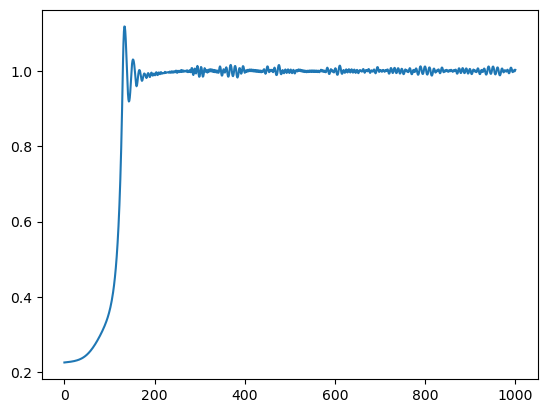

In [43]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt

num_qubits = 8

batch_size = 8

num_epochs = 1001

learning_rate = 1e-3

n = 3
N = 2**n

loss_graph = []

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(-2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        dataset = []
        labels = []

        for i in range(num_qubits):
            phi = np.random.rand() * 2*np.pi
            theta = np.random.rand() * np.pi

            input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
            dataset.append(input_qubit)

            q = input_qubit
            q0 = torch.tensor([1,0], dtype=torch.complex128)

            for i in range(n-1):
                q = torch.kron(q,q0)
            q = q @ F
            labels.append(q)
            
        self.dataset = torch.stack((dataset[0],dataset[1],dataset[2],dataset[3],dataset[4],dataset[5],dataset[6],dataset[7]))
        self.labels = torch.stack((labels[0],labels[1],labels[2],labels[3],labels[4],labels[5],labels[6],labels[7]))
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

class HModel(torch.nn.Module):
    
    def __init__(self):
        super(HModel, self).__init__()
        self.w = Parameter(torch.rand(1, dtype=torch.complex128))
      
    def forward(self, x):
        w = self.w
        
        F = torch.zeros((N,N), dtype=torch.complex128)
        
        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)
            
        q=x
        
        for i in range(n-1):
            q0 = torch.tensor([1,0], dtype=torch.complex128)
            q = torch.kron(q,q0)
            
        return q @ F
    
model = HModel()

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')
        
model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

print(q_out)

x_graph = np.arange(num_epochs * num_qubits / batch_size)
plt.plot(x_graph,loss_graph)